# Pneumonia Detection Using ResNet


In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [10]:
! kaggle datasets download paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:10<00:00, 204MB/s]
100% 2.29G/2.29G [00:10<00:00, 242MB/s]


In [11]:
! unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam
import os
import cv2 as cv
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from skimage import exposure 
from imblearn.over_sampling import SMOTE
import random
import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
from keras.callbacks import ReduceLROnPlateau
from sklearn.utils import class_weight

In [15]:
%tensorflow_version 2.7
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Found GPU at: /device:GPU:0


#Augmentation

in this section, while reading the dataset, we use MUSICA image enhancement algorithm to make images more clear for deep learning model and have more contrast in the image. in order to do this we make laplacian pyramid and apply a gloabl enhancement method on each level.

In [16]:
def global_enhancement(I):
    return(np.tanh(I/16) * max(np.max(I), np.abs(np.min(I))))

def up_sample_blur(I):
    I_e = cv.pyrUp(I)

    return(I_e)
    
def down_sample(I):
    I_d = cv.pyrDown(I)

    return(I_d)

def image_pyramid(I, n_levels):
    lst = list()
    
    I = np.float32(I)
    
    for i in range(0, n_levels):
        I_d = down_sample(I)
        D = I - up_sample_blur(I_d)
        lst.append(D)
        
        I = I_d
        
    lst.append(I)
    
    return(lst)

def image_pyramid_rec(lst, n_levels):
    
    I = lst[n_levels]
    
    for i in range(n_levels, 0, -1):
        I = up_sample_blur(I) + lst[i-1]
        
    return(I)

def enhance(I):
  prm = image_pyramid(I, 3)

  for i in range(0, 3):
    prm[i] = global_enhancement(prm[i])

  return image_pyramid_rec(prm, 3)

In [17]:
def read_data(root, size):
    data, labels = [], []
    for path, subdirs, files in os.walk(root):
        for file in files:
            img = cv.imread(path + '/' + file)
            img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            img = cv.resize(img, (size, size))
            img = enhance(img)
            img = img - np.min(img)
            img = (img / np.max(img)) * 255
            data.append(cv.merge((img, img, img)))
            class_name = path.split('/')[-1]
            # data.append(exposure.equalize_hist(img[30:-30, 30:-30]) * 255)
            labels.append(class_name)
    return np.array(data), np.array(labels)

In [23]:
train_path = "chest_xray/train"
val_path = "chest_xray/val"
test_path = "chest_xray/test"

number_of_classes = 2
batch_size = 32
size = 200

train_data, train_label = read_data(train_path, size)
val_data, val_label  = read_data(val_path, size)
test_data, test_label  = read_data(test_path, size)

In [24]:
le = LabelEncoder() 
le.fit(train_label) 
train_label = le.transform(train_label) 
val_label = le.transform(val_label)

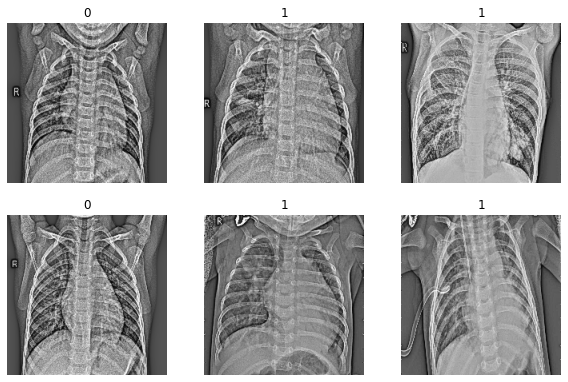

In [25]:
plt.figure(figsize=(10, 10))
indexes = random.sample(range(1, len(train_data)), 6)
for i, img in enumerate(train_data[indexes]):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(img.astype('uint8'))
  # print(train_data[i][1, 1, 1])
  plt.title(train_label[indexes[i]])
  plt.axis("off")

Here we use data augmentation techniques to increase size of the dataset and have more images to help training part. for example here we flipped images, apply rotate , zoom, ... functions on them. 

In [30]:
from keras.preprocessing.image import ImageDataGenerator

generator = ImageDataGenerator(
  rescale=1./255,
  featurewise_center = False,
  samplewise_center = False,
  featurewise_std_normalization = False,
  samplewise_std_normalization = False,
  zca_whitening=False,
  rotation_range =30,
  zoom_range = 0.2,
  width_shift_range = 0.1,
  height_shift_range = 0.1,
  horizontal_flip = True,
  vertical_flip = False)
  
generator.fit(train_data)

#Residual Network Model

A ResNet is an upgraded version of the VGG models, with the difference between them being the skip connections used in ResNets. As we went deeper into a network the vanishing gradient problem becomes more and more significant and the solution to this problem was using a skip connection.
To build a REsNet model, we start to build identitty and convolutional blocks and use them to build our ResNet model.

https://arxiv.org/abs/1512.03385

In [33]:
def identity_block(X, f, filters):
    X_shortcut = X
    
    X = Conv2D(filters = filters[0], kernel_size = (1, 1), strides = (1,1), padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    
    X = Conv2D(filters = filters[1], kernel_size = (f, f), strides = (1,1), padding = 'same', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    X = Conv2D(filters = filters[2], kernel_size = (1, 1), strides = (1,1), padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [34]:
def convolutional_block(X, f, filters, s = 2):
    X_shortcut = X

    X = Conv2D(filters = filters[0], kernel_size= (1, 1), strides = (s,s),padding="valid", kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    
    X = Conv2D(filters = filters[1], kernel_size=(f,f), strides=(1,1), padding="same",kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    X = Conv2D(filters = filters[2], kernel_size=(1,1), strides = (1,1), padding="valid", kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3)(X)

    X_shortcut = Conv2D(filters = filters[2], kernel_size= (1,1), strides=(s,s), padding="valid", kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3)(X_shortcut)

    X = Add()([X_shortcut,X])
    X = Activation("relu")(X)

    return X

In [35]:
def Network(input_shape = (64, 64, 3), classes = 6):
    X_input = Input(input_shape)
    X = ZeroPadding2D((3, 3))(X_input)
    
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

    X = convolutional_block(X, f=3, filters = [128,128,512], s=2)
    X = identity_block(X, 3, filters = [128,128,512])
    X = identity_block(X, 3, filters = [128,128,512])
    X = identity_block(X, 3, filters = [128,128,512])

    X = convolutional_block(X, f=3, filters = [256,256,1024], s=2)
    X = identity_block(X, 3, filters = [256,256,1024])
    X = identity_block(X, 3, filters = [256, 256, 1024])
    X = identity_block(X, 3, filters= [256,256,1024])
    X = identity_block(X, 3, filters=[256,256,1024])
    X = identity_block(X, 3, filters=[256,256,1024])

    X = convolutional_block(X, f=3, filters=[256,256,2048], s=3)
    X = identity_block(X, 3, filters=[256,256,2048])
    X = identity_block(X,3, filters=[256,256,2048])

    X = Flatten()(X)
    X = Dense(512, activation='relu')(X)
    X = Dense(classes, activation='sigmoid')(X)
    
    return Model(inputs = X_input, outputs = X, name='ResNet50')

In [40]:
model = Network(input_shape=(200, 200, 3), classes=1)

In [41]:
model.compile(optimizer=Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])

In [42]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=0, factor=0.7, min_lr=0.000000001)

In [43]:
history = model.fit(generator.flow(train_data, train_label, batch_size=32), epochs=40, validation_data=generator.flow(val_data, val_label), callbacks=[learning_rate_reduction])

Epoch 1/40
163/163 [==============================] - 67s 364ms/step - loss: 3.4199 - accuracy: 0.7488 - val_loss: 0.8902 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/40
163/163 [==============================] - 58s 358ms/step - loss: 0.3164 - accuracy: 0.8591 - val_loss: 4.5684 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/40
163/163 [==============================] - 59s 358ms/step - loss: 0.2731 - accuracy: 0.8888 - val_loss: 6.0336 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/40
163/163 [==============================] - 58s 357ms/step - loss: 0.2299 - accuracy: 0.9112 - val_loss: 1.8401 - val_accuracy: 0.5000 - lr: 7.0000e-04
Epoch 5/40
163/163 [==============================] - 60s 369ms/step - loss: 0.2189 - accuracy: 0.9208 - val_loss: 1.9352 - val_accuracy: 0.5625 - lr: 7.0000e-04
Epoch 6/40
163/163 [==============================] - 58s 355ms/step - loss: 0.1790 - accuracy: 0.9319 - val_loss: 2.8879 - val_accuracy: 0.5625 - lr: 7.0000e-04
Epoch 7/40
163/163 [====================

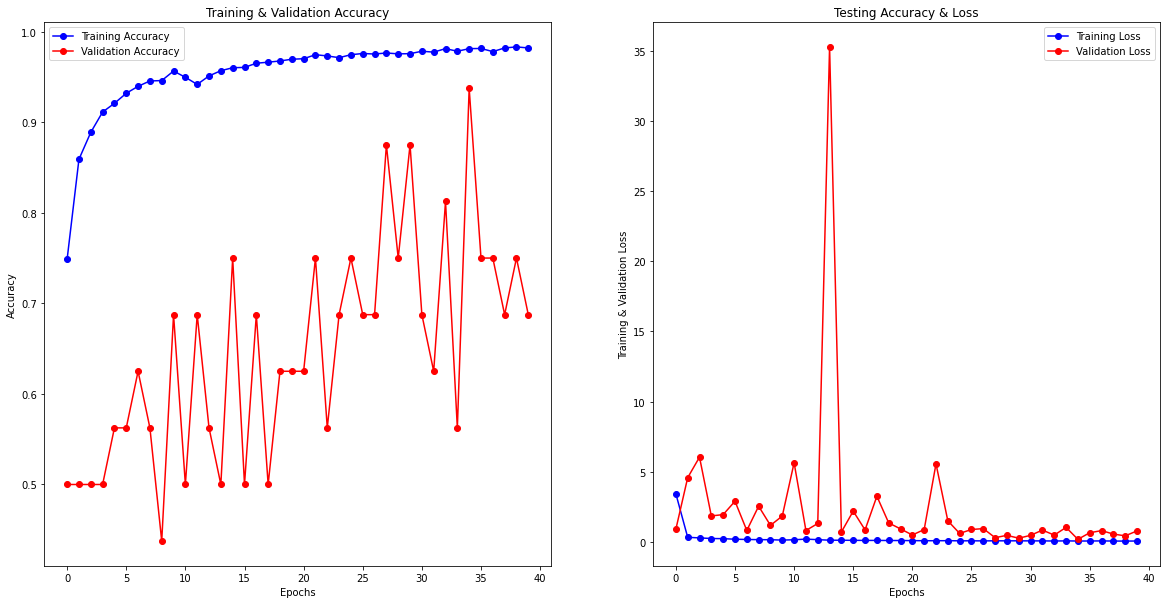

In [45]:
epochs = [i for i in range(40)]
fig , ax = plt.subplots(1, 2)
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , history.history['accuracy'] , 'bo-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , history.history['loss'] , 'b-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

#Transfer Learning

Here we use ResNet50 Model in keras and ImageNet weights as out model to perform classification.

In [44]:
resnet_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(200, 200, 3),
                   pooling='avg',
                   weights='imagenet')

for layer in resnet_model.layers:
        layer.trainable=False

model = keras.models.Sequential()
model.add(resnet_model)
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               1049088   
                                                                 
 dense_7 (Dense)             (None, 1)                 513       
                                                                 
Total params: 24,637,313
Trainable params: 1,049,601
Non-trainable params: 23,587,712
_________________________________________________________________


In [27]:
model.compile(optimizer=Adam(0.001),loss='binary_crossentropy',metrics=['accuracy'])

In [28]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=0, factor=0.7, min_lr=0.000000001)

In [31]:
history = model.fit(generator.flow(train_data, train_label, batch_size=32), epochs=40, validation_data=generator.flow(val_data, val_label, batch_size=32), callbacks=[learning_rate_reduction])

Epoch 1/40
163/163 [==============================] - 58s 298ms/step - loss: 0.5688 - accuracy: 0.7306 - val_loss: 0.8830 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/40
163/163 [==============================] - 47s 288ms/step - loss: 0.4464 - accuracy: 0.7789 - val_loss: 1.2134 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/40
163/163 [==============================] - 47s 289ms/step - loss: 0.4153 - accuracy: 0.7995 - val_loss: 0.9612 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 4/40
163/163 [==============================] - 47s 290ms/step - loss: 0.3868 - accuracy: 0.8125 - val_loss: 0.6570 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 5/40
163/163 [==============================] - 47s 290ms/step - loss: 0.3962 - accuracy: 0.8123 - val_loss: 0.8599 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 6/40
163/163 [==============================] - 47s 290ms/step - loss: 0.3472 - accuracy: 0.8411 - val_loss: 1.3117 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 7/40
163/163 [==============================] 

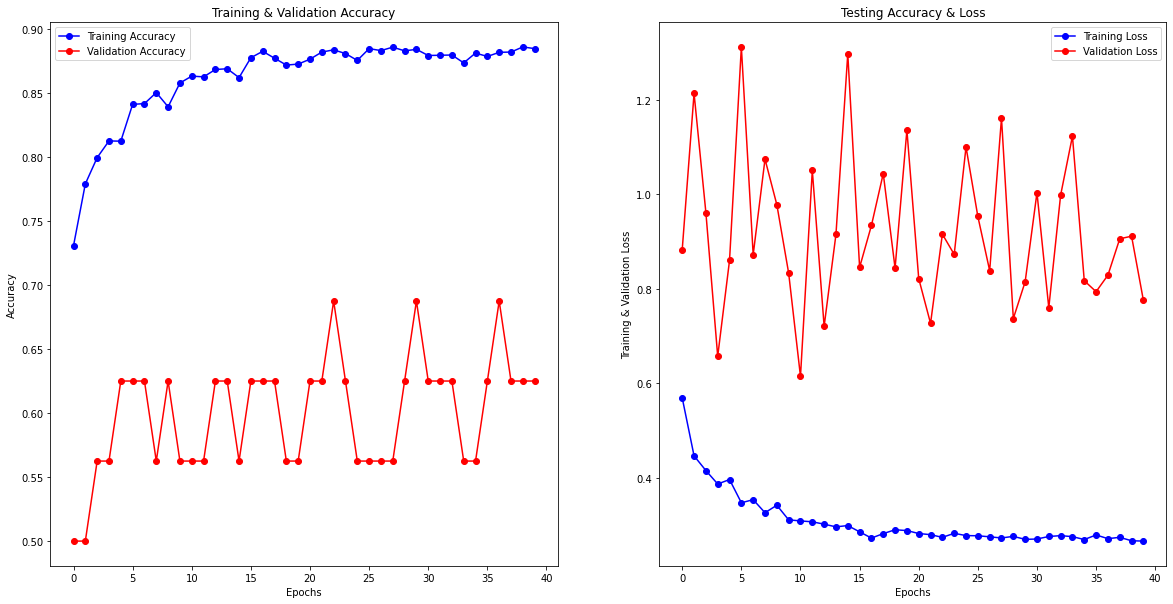

In [32]:
epochs = [i for i in range(40)]
fig , ax = plt.subplots(1, 2)
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , history.history['accuracy'] , 'bo-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , history.history['loss'] , 'b-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

# Interpretability

Here we used GradCam mathod to show how our model is working.
This method shows what our convolutional neural network sees and understands when making a decision.

We run the input through the model, grab the layer output(last convolutional layer) and we find the gradient of the output layer. Then we just pick sections of the gradient which contribute to the prediction. Then add the heat-map to the original image.

https://arxiv.org/pdf/1610.02391.pdf

In [58]:
class GradCAM:
	def __init__(self, model):
		self.model = model
		self.layerName = self.find_target_layer()
  
	def find_target_layer(self):
		for layer in reversed(self.model.layers):
			if len(layer.output_shape) == 4:
				return layer.name
  
	def compute_heatmap(self, image):
		gradModel = Model( inputs=[self.model.inputs], 
		                  outputs=[self.model.get_layer(self.layerName).output,
											self.model.output])
  
		with tf.GradientTape() as tape:
			inputs = tf.cast(image, tf.float32)
			conv_outputs, predictions = gradModel(inputs)
			loss = predictions[:, 1]

		grads = tape.gradient(loss, conv_outputs)
		castConvOutputs = tf.cast(conv_outputs > 0, "float32")
		castGrads = tf.cast(grads > 0, "float32")
		guidedGrads = castConvOutputs * castGrads * grads
		conv_outputs, guidedGrads = conv_outputs[0], guidedGrads[0]

		weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
		cam = tf.reduce_sum(tf.multiply(weights, conv_outputs), axis=-1)
  
		heatmap = cv.resize(cam.numpy(), (image.shape[2], image.shape[1]))
		heatmap = (heatmap - np.min(heatmap)) / ((heatmap.max() - heatmap.min()))
		return (heatmap * 255).astype("uint8")

	def overlay_heatmap(self, heatmap, image, alpha=0.5,
		colormap=cv.COLORMAP_VIRIDIS):
		heatmap = cv.applyColorMap(heatmap, colormap)
		output = cv.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
		return output

In [62]:
def get_grad_cam(orig, image):
  image = keras.utils.img_to_array(image)
  image = np.expand_dims(image, axis=0)
  image = keras.applications.imagenet_utils.preprocess_input(image)

  cam = GradCAM(model)
  heatmap = cam.compute_heatmap(image)
  heatmap = cv.resize(heatmap, (orig.shape[1], orig.shape[0]))
  return cam.overlay_heatmap(heatmap, orig, alpha=0.5)

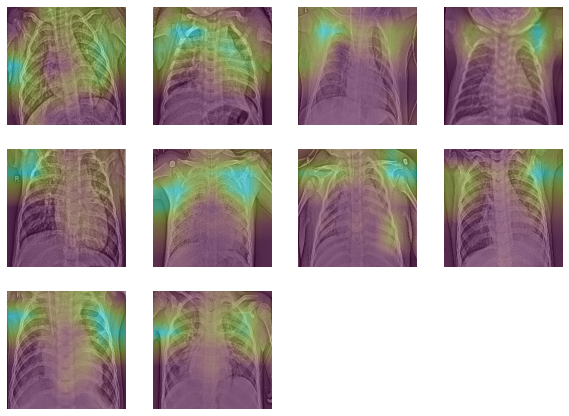

In [78]:
plt.figure(figsize=(10, 10))
pne = train_data[train_label == 1]
indexes = random.sample(range(1, len(pne)), 10)
for i, image in enumerate(pne[indexes]):
  ax = plt.subplot(4, 4, i + 1)
  orig = image.astype('uint8')
  image = image.astype('uint8')
  image = get_grad_cam(orig, image)
  plt.imshow(image)
  plt.axis("off")

# Imbalance Data

we can plot number of images in each class. as we see this dataset is imbalamced and the distribution of classes is unequal. if we pick one image from this dataset, this selection is not uniform and this affects on training the model. if we have so many images from some class the model learns to predict images like that distribution.

We can calculate this distribution and weights of classes and give this as an input to the model.

Text(0.5, 1.0, 'Case Distribution')

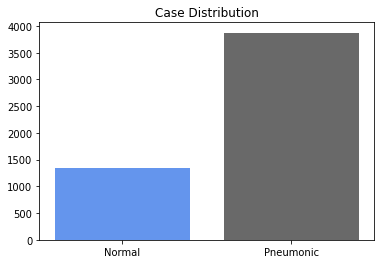

In [ ]:
pneumonia_count = len(train_label[train_label == 1])
normal_count = len(train_label[train_label == 0])

fig, ax = plt.subplots()
ax.bar(height=[normal_count, pneumonia_count], x=["Normal", "Pneumonic"], color=["cornflowerblue", "dimgray"])
plt.title("Case Distribution")

In [46]:
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                 classes=np.unique(train_label),
                                                 y=train_label)
class_weights = {i : class_weights[i] for i in range(2)}

In [53]:
model = Network(input_shape=(200, 200, 3), classes=1)

In [54]:
model.compile(optimizer=Adam(0.001),loss='binary_crossentropy',metrics=['accuracy'])

In [55]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=0, factor=0.7, min_lr=0.000000001)

In [56]:
history = model.fit(generator.flow(train_data, train_label, batch_size=32), epochs=40, validation_data=generator.flow(val_data, val_label), callbacks=[learning_rate_reduction], class_weight=class_weights)

Epoch 1/40
163/163 [==============================] - 71s 365ms/step - loss: 7.1610 - accuracy: 0.6737 - val_loss: 7745.1074 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/40
163/163 [==============================] - 59s 358ms/step - loss: 0.8871 - accuracy: 0.7364 - val_loss: 11958.7744 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/40
163/163 [==============================] - 59s 358ms/step - loss: 0.5272 - accuracy: 0.8058 - val_loss: 50.7184 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/40
163/163 [==============================] - 59s 362ms/step - loss: 0.3462 - accuracy: 0.8689 - val_loss: 78.6849 - val_accuracy: 0.5625 - lr: 7.0000e-04
Epoch 5/40
163/163 [==============================] - 58s 357ms/step - loss: 0.3476 - accuracy: 0.8888 - val_loss: 30.0819 - val_accuracy: 0.5000 - lr: 7.0000e-04
Epoch 6/40
163/163 [==============================] - 58s 357ms/step - loss: 0.3603 - accuracy: 0.8917 - val_loss: 3.3072 - val_accuracy: 0.5625 - lr: 7.0000e-04
Epoch 7/40
163/163 [==========

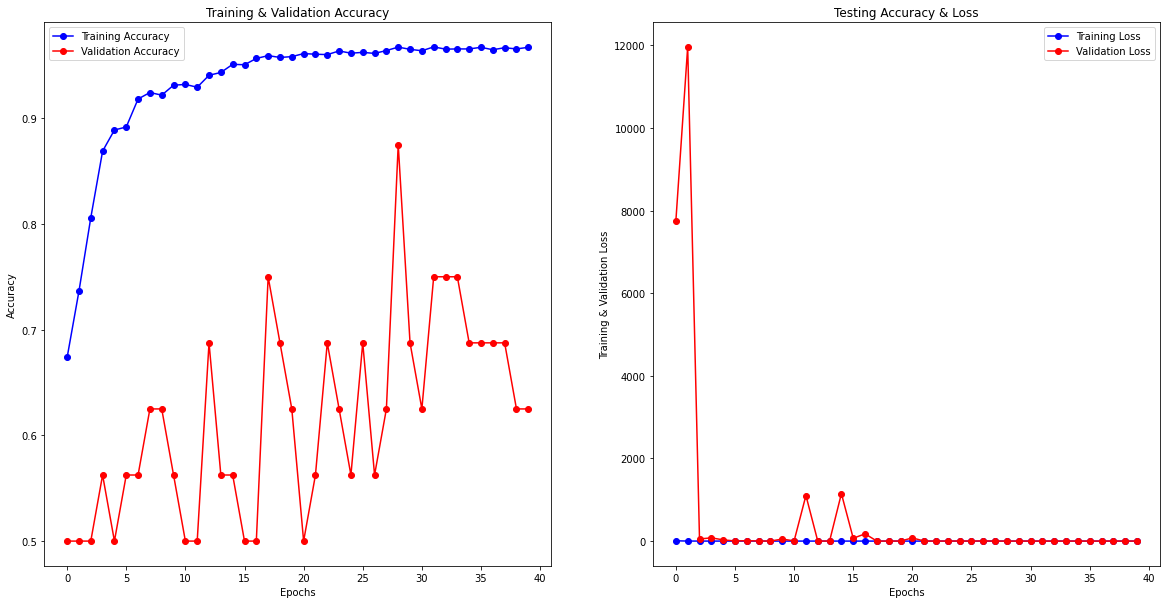

In [57]:
epochs = [i for i in range(40)]
fig , ax = plt.subplots(1, 2)
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , history.history['accuracy'] , 'bo-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , history.history['loss'] , 'b-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()